# Noteboook for t2max verification with ensemble scores
## Verification of dressed forecasts using climate percentiles
(requires to run notebook_get_forecast_single.ipynb first if you want to assess your own set of forecasts)

Assessing dressed forecasts against observations using a local climatology for score computation. 

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from utils.utils_data  import get_obs
from utils.utils_data  import get_fct

from utils.utils_data  import get_domain
from utils.utils_stats import get_weights
from utils.utils_stats import dressing

from utils.utils_scores import get_scores_thr
from utils.utils_scores import get_score
from utils.utils_plots  import plot_scores
from utils.utils_plots  import plot_simple_scores

### 1. Settings

In [3]:
# where the data sit or will sit
path_data     = "/my/data/folder/seeps4all/"
path_data     = "/ec/res4/scratch/mozb/hackathon/t2max"

# forecasts
name_forecasts = [
                  "fct_od_0001_t2max_europe_20231201_to_20240229_1200_ecad",
                  "fct_ml_aifs_t2max_europe_20231201_to_20240229_1200_ecad",
                  "fct_ml_dmgc_t2max_europe_20231201_to_20240229_1200_ecad",
                  "fct_ml_pguw_t2max_europe_20231201_to_20240229_1200_ecad"
                 ]
#name_forecasts = [
#                  "fct_od_0001_t2max_europe_20240301_to_20240531_1200_ecad",
#                  "fct_ml_aifs_t2max_europe_20240301_to_20240531_1200_ecad",
#                  "fct_ml_dmgc_t2max_europe_20240301_to_20240531_1200_ecad",
#                  "fct_ml_pguw_t2max_europe_20240301_to_20240531_1200_ecad"
#                 ]
#name_forecasts = [
#                  "fct_od_0001_t2max_europe_20240601_to_20240831_1200_ecad",
#                  "fct_ml_aifs_t2max_europe_20240601_to_20240831_1200_ecad",
#                  "fct_ml_dmgc_t2max_europe_20240601_to_20240831_1200_ecad",
#                  "fct_ml_pguw_t2max_europe_20240601_to_20240831_1200_ecad"
#                 ]
#name_forecasts = [
#                  "fct_od_0001_t2max_europe_20240901_to_20241130_1200_ecad",
#                  "fct_ml_aifs_t2max_europe_20240901_to_20241130_1200_ecad",
#                  "fct_ml_dmgc_t2max_europe_20240901_to_20241130_1200_ecad",
#                  "fct_ml_pguw_t2max_europe_20240901_to_20241130_1200_ecad"
#                 ]

# colours and names 
colors = ["tab:red","darkred","tab:blue","tab:purple"]
labels = ["IFS", "AIFS", "GraphCast", "PanguWeather" ]

delta_x = [9,25,25,25]

# ouput path and prefix
prefig = "./prefix"


### 2. Read observations (+ metadata, + climate) and forecasts

In [4]:
# open data
obs_data = get_obs(path_data,"clim",obs_origin="ecad",param="t2max")
fct_data = get_fct(path_data,name_forecasts)

open: /ec/res4/scratch/mozb/hackathon/t2max/obs_clim_t2max_2022_2024_ecad.zarr
... total number of observation locations: 5165
open: /ec/res4/scratch/mozb/hackathon/t2max/fct_od_0001_t2max_europe_20231201_to_20240229_1200_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91
open: /ec/res4/scratch/mozb/hackathon/t2max/fct_ml_aifs_t2max_europe_20231201_to_20240229_1200_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91
open: /ec/res4/scratch/mozb/hackathon/t2max/fct_ml_dmgc_t2max_europe_20231201_to_20240229_1200_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91
open: /ec/res4/scratch/mozb/hackathon/t2max/fct_ml_pguw_t2max_europe_20231201_to_20240229_1200_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91


### 3. Domain and station weighting 

In [5]:
# verification domain
domain = "europe" # default otherwise define
obs_data,fct_data = get_domain(obs_data,fct_data,domain)

focus on domain europe


In [6]:
fct_data[0]

<xarray.Dataset> Size: 38MB
Dimensions:   (stnid: 5165, step: 10, run: 91)
Coordinates:
    elev      (stnid) int64 41kB dask.array<chunksize=(5165,), meta=np.ndarray>
    lat       (stnid) float64 41kB dask.array<chunksize=(5165,), meta=np.ndarray>
    lon       (stnid) float64 41kB dask.array<chunksize=(5165,), meta=np.ndarray>
    orog      (stnid) float64 41kB dask.array<chunksize=(5165,), meta=np.ndarray>
  * run       (run) datetime64[ns] 728B 2023-12-01T12:00:00 ... 2024-02-29T12...
  * step      (step) timedelta64[ns] 80B 1 days 2 days 3 days ... 9 days 10 days
  * stnid     (stnid) int64 41kB 13 14 15 16 21 ... 27909 27911 27912 27957
Data variables:
    forecast  (step, run, stnid) float64 38MB dask.array<chunksize=(3, 23, 1292), meta=np.ndarray>
Attributes:
    description:  forecasts at station locations

In [7]:
# weighting: "uniform" or "station_weighting"
weights = get_weights(obs_data,"station_weighting")

weights based on station density


### 4. Dress the forecast
(to derive a pseudo-ensemble)

In [8]:
# generalised model 
fct_data = dressing(fct_data,delta_x,nmem=10,param="2t")

In [9]:
#Check one output 
if False:
    fig = plt.figure(figsize=(4,3.5))
    plt.plot(fct[0,0,:],fct_dressed[0,0,0,:],".k")
    plt.xlabel("forecast")
    plt.ylabel("dressed forecast")
  

Compute brier score for a given threshold (key) over verification period for each forecast lead time

In [10]:
# percentiles of the local climatology used as thresholds
thresholds = ("perc65","perc70","perc75","perc80","perc85","perc90","perc95","perc98","perc99") 

bs,eds = get_scores_thr(obs_data,fct_data, weights,thresholds)

experiment 0, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 1, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 2, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 3, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 


In [11]:
# info for plotting
plot_info= dict()
plot_info["prefig"]     = prefig
plot_info["colors"]     = colors
plot_info["labels"]     = labels
plot_info["thresholds"] = thresholds

Plotting Brier score

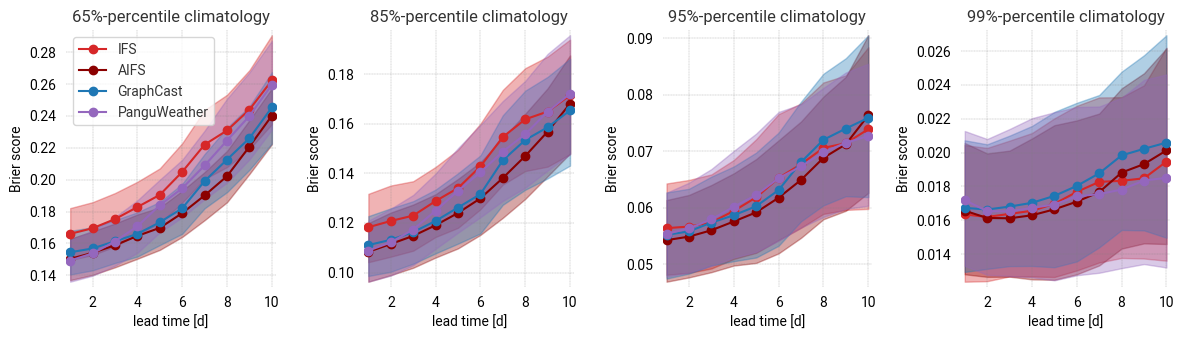

In [12]:
plot_scores(bs,"Brier score",plot_info,along="steps",x_list=[0,4,6,8])

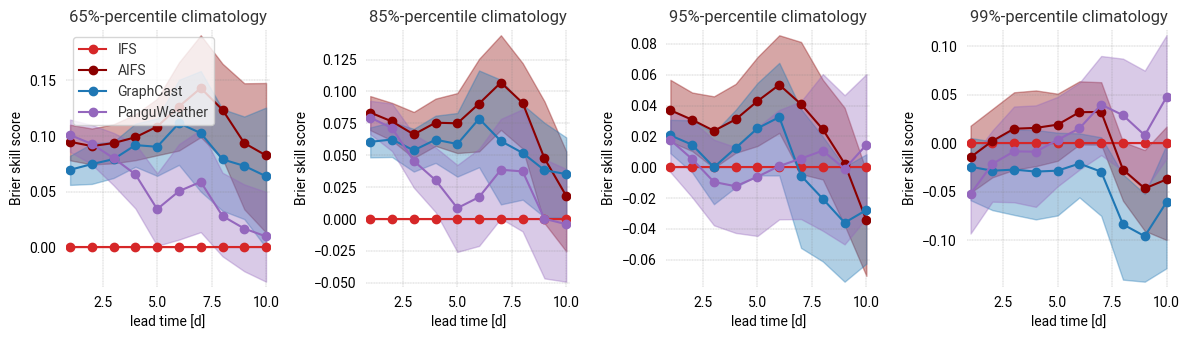

In [13]:
plot_scores(bs,"Brier skill score",plot_info,along="steps",x_list=[0,4,6,8])

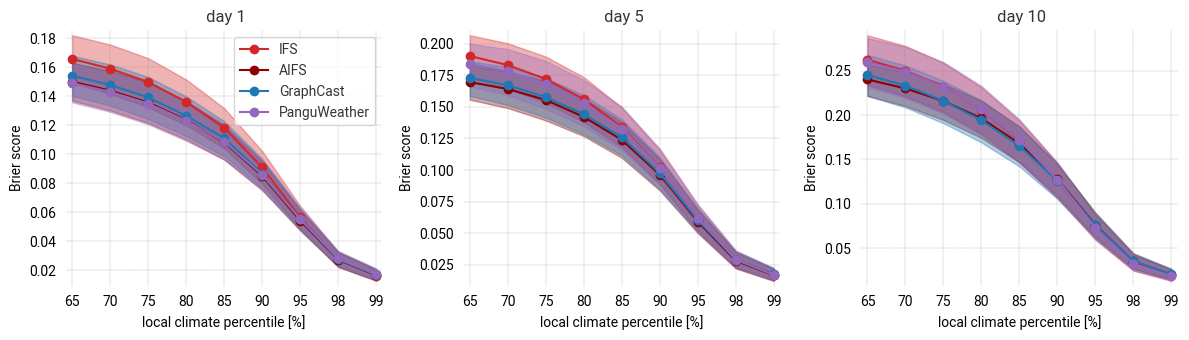

In [14]:
plot_scores(bs,"Brier score",plot_info,along="thresholds",x_list=[0,4,9])

Plotting elementary diagonal score

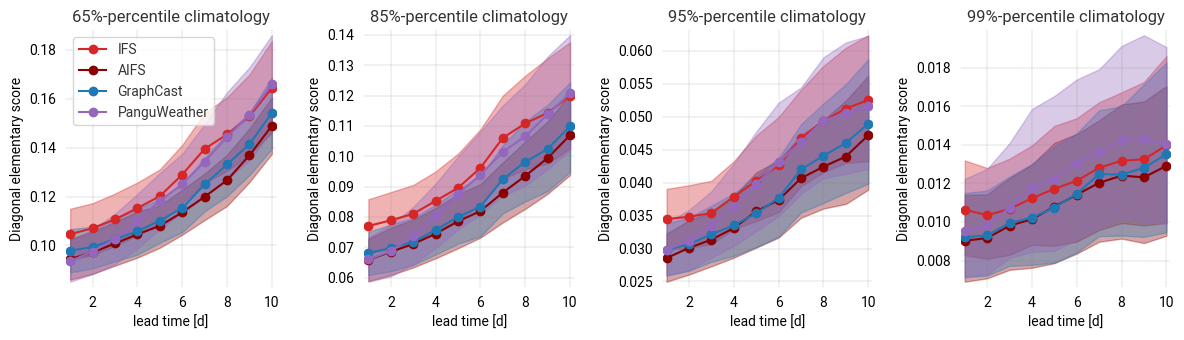

In [15]:
plot_scores(eds,"Diagonal elementary score",plot_info,along="steps",x_list=[0,4,6,8])

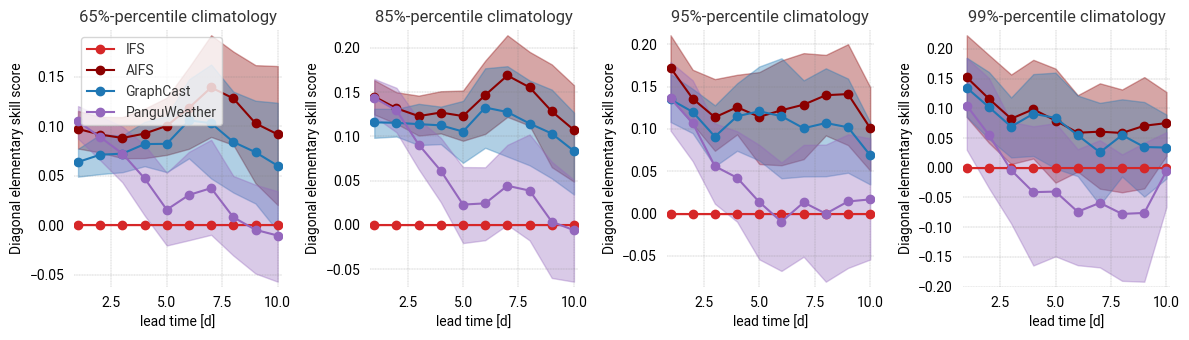

In [16]:
plot_scores(eds,"Diagonal elementary skill score",plot_info,along="steps",x_list=[0,4,6,8])

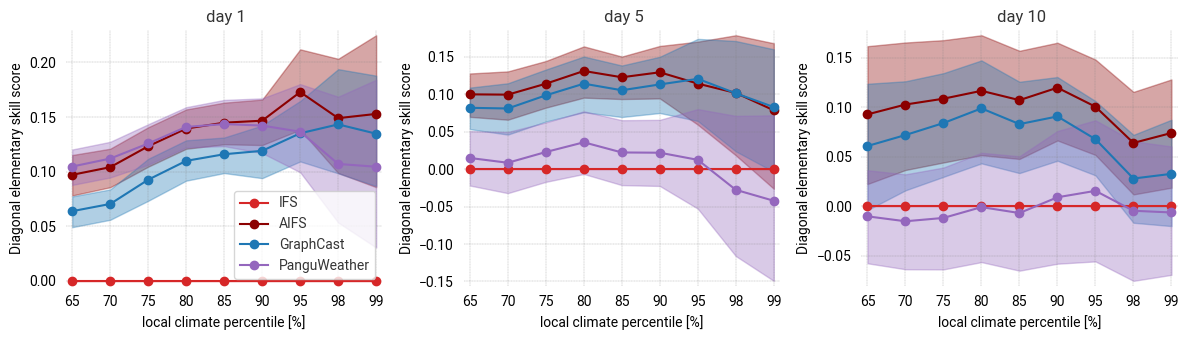

In [17]:
plot_scores(eds,"Diagonal elementary skill score",plot_info,along="thresholds",x_list=[0,4,9])

### 5. Compute and plot DIAGS

In [18]:
diags = get_score(obs_data,fct_data,weights,"diags")

experiment 0, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 1, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 2, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 3, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 


plots 

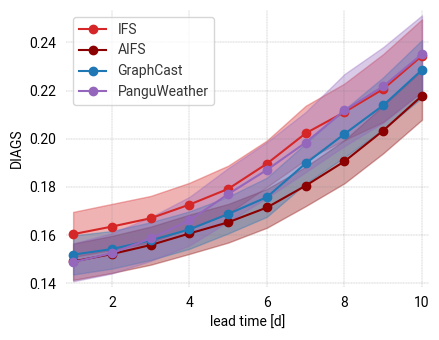

In [19]:
plot_simple_scores(diags,"DIAGS",plot_info)

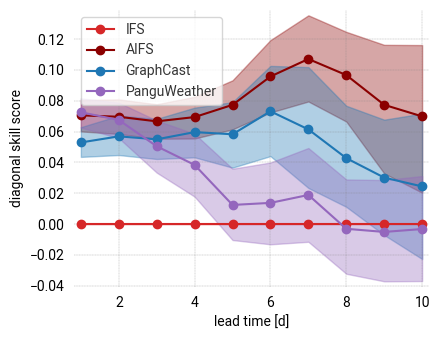

In [20]:
plot_simple_scores(diags,"diagonal skill score",plot_info)

End of the Notebook